In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
df = pd.read_csv(r'C:\Users\91931\Downloads\Real Estate Analysis\Indian_housing_Mumbai_data.csv')

In [3]:
df.head()

,house_type,house_size,location,city,latitude,longitude,price,currency,numBathrooms,numBalconies,isNegotiable,priceSqFt,verificationDate,description,SecurityDeposit,Status
0,2 BHK Apartment,"1,180 sq ft",Ulwe,Mumbai,18.971046,73.017723,19000,INR,2.0,NaN,NaN,NaN,Posted 2 years ago,It has area of 1180 sqft and is available at a...,No Deposit,Furnished
1,2 BHK Apartment,"1,120 sq ft",Ulwe,Mumbai,18.966377,73.012802,12500,INR,2.0,NaN,NaN,NaN,Posted 2 years ago,Well designed 2 bhk multistorey apartment is a...,No Deposit,Unfurnished
2,2 BHK Apartment,"1,200 sq ft",Panvel,Mumbai,18.965979,73.124649,22000,INR,2.0,NaN,NaN,NaN,Posted a month ago,A spacious 2 bhk multistorey apartment is avai...,No Deposit,Unfurnished
3,2 BHK Apartment,750 sq ft,Kandivali West,Mumbai,19.213598,72.833633,28500,INR,2.0,NaN,NaN,NaN,Posted 3 years ago,It has a built-up area of 750 sqft and is avai...,No Deposit,Unfurnished
4,3 BHK Apartment,"1,400 sq ft",Chembur,Mumbai,19.062933,72.892395,50000,INR,3.0,NaN,NaN,NaN,Posted 3 years ago,The house is semi-furnished. It has power back...,No Deposit,Semi-Furnished


# 1. Data Cleaning and Feature Engineering

In [4]:

df_cleaned = df.copy()


In [5]:
# Step 1 - Clean `house_size`
# Remove 'sq ft' and commas, then convert to numeric (float)
df_cleaned['house_size_sqft'] = df_cleaned['house_size'].str.replace(' sq ft', '', regex=False).str.replace(',', '', regex=False).astype(float)

In [6]:
# Step 2 - Drop Irrelevant and Null Columns
columns_to_drop = [
    'priceSqFt', 'currency', 'city', 'house_size', 
    'isNegotiable', 'verificationDate', 'description'
]
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

In [7]:
# Step 3 - Handle NaNs in `numBathrooms` and `numBalconies`
# Impute with 0 and convert to integer
df_cleaned['numBathrooms'] = df_cleaned['numBathrooms'].fillna(0).astype(int)
df_cleaned['numBalconies'] = df_cleaned['numBalconies'].fillna(0).astype(int)

In [8]:
#  Step 4 - Feature Creation: `price_per_sqft` (Rental Yield proxy)
df_cleaned['price_per_sqft'] = df_cleaned['price'] / df_cleaned['house_size_sqft']

# 2. Exploratory Data Analysis (EDA)


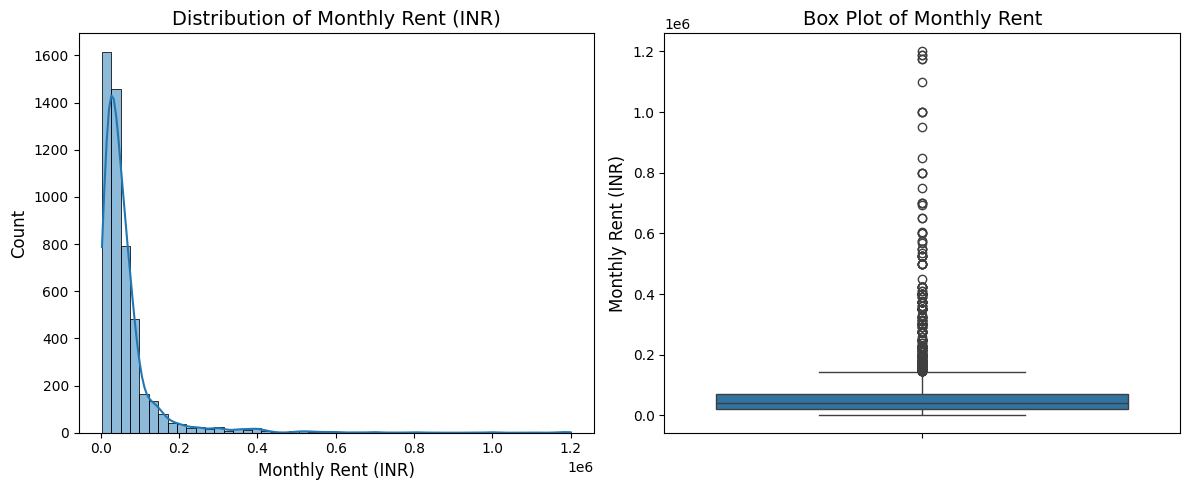

In [9]:
# Step 1- Distribution of Monthly Rent
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['price'], bins=50, kde=True)
plt.title('Distribution of Monthly Rent (INR)', fontsize=14)
plt.xlabel('Monthly Rent (INR)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(y=df_cleaned['price'])
plt.title('Box Plot of Monthly Rent', fontsize=14)
plt.ylabel('Monthly Rent (INR)', fontsize=12)

plt.tight_layout()
plt.savefig('monthly_rent_distribution.png')
plt.show()

C:\Users\91931\AppData\Local\Temp\ipykernel_22476\662478465.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_avg_price.index, y=location_avg_price.values, palette="viridis")


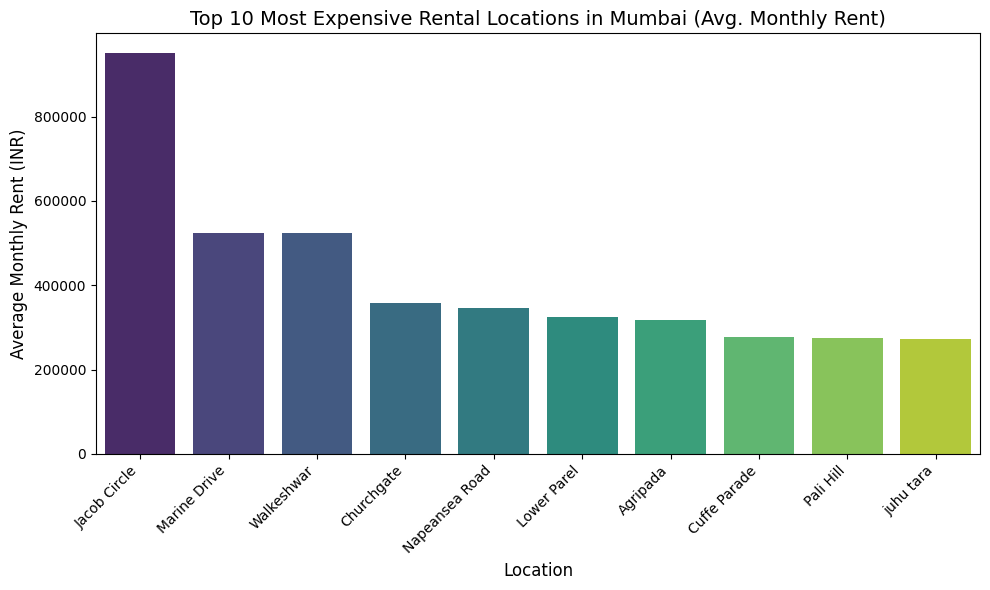

In [10]:
# Step 2 - Top 10 Most Expensive Rental Locations
location_avg_price = df_cleaned.groupby('location')['price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=location_avg_price.index, y=location_avg_price.values, palette="viridis")
plt.title('Top 10 Most Expensive Rental Locations in Mumbai (Avg. Monthly Rent)', fontsize=14)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Average Monthly Rent (INR)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.savefig('top_10_locations_avg_rent.png')
plt.show()


# 3. Geospatial Rental Market Analysis 


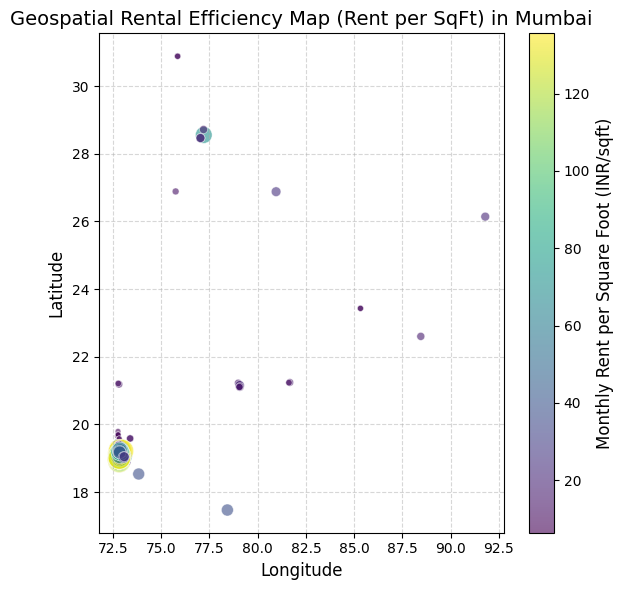

In [11]:

# Filter for a reasonable range of price_per_sqft to reduce noise
price_per_sqft_cap = df_cleaned['price_per_sqft'].quantile(0.95)
df_viz = df_cleaned[df_cleaned['price_per_sqft'] < price_per_sqft_cap].copy()

plt.figure(figsize=(6, 6))
scatter = plt.scatter(
    df_viz['longitude'],
    df_viz['latitude'],
    c=df_viz['price_per_sqft'],
    s=df_viz['price_per_sqft'] * 2,
    cmap='viridis',
    alpha=0.6,
    edgecolors='w',
    linewidths=0.5
)

cbar = plt.colorbar(scatter, label='Monthly Rent per Square Foot (INR/sqft)')
cbar.set_label('Monthly Rent per Square Foot (INR/sqft)', fontsize=12)

plt.title('Geospatial Rental Efficiency Map (Rent per SqFt) in Mumbai', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('geospatial_rental_efficiency.png')
plt.show()

# 4. Predictive Modeling

In [13]:
# Step 1 - Feature Preparation and Encoding
# Select top 20 most frequent locations and group the rest as 'Other'
top_n = 20
top_locations = df_cleaned['location'].value_counts().nlargest(top_n).index
df_cleaned['location_grouped'] = np.where(df_cleaned['location'].isin(top_locations), df_cleaned['location'], 'Other')

# Drop irrelevant columns for modeling and the original location
df_model = df_cleaned.drop(columns=['location', 'SecurityDeposit', 'price_per_sqft', 'latitude', 'longitude'])

# One-Hot Encoding
categorical_features = ['house_type', 'Status', 'location_grouped']
df_model_encoded = pd.get_dummies(df_model, columns=categorical_features, drop_first=True)

# Define Features (X) and Target (y)
X = df_model_encoded.drop('price', axis=1)
y = df_model_encoded['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Step 2 - Train Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,15
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
# Step 3 -  Evaluate Model
y_pred = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n--- Model Performance ---")
print(f"R-squared (R2 Score): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:,.0f} INR")


--- Model Performance ---
R-squared (R2 Score): 0.7798
Mean Absolute Error (MAE): 20,945 INR


C:\Users\91931\AppData\Local\Temp\ipykernel_22476\361372959.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="mako")


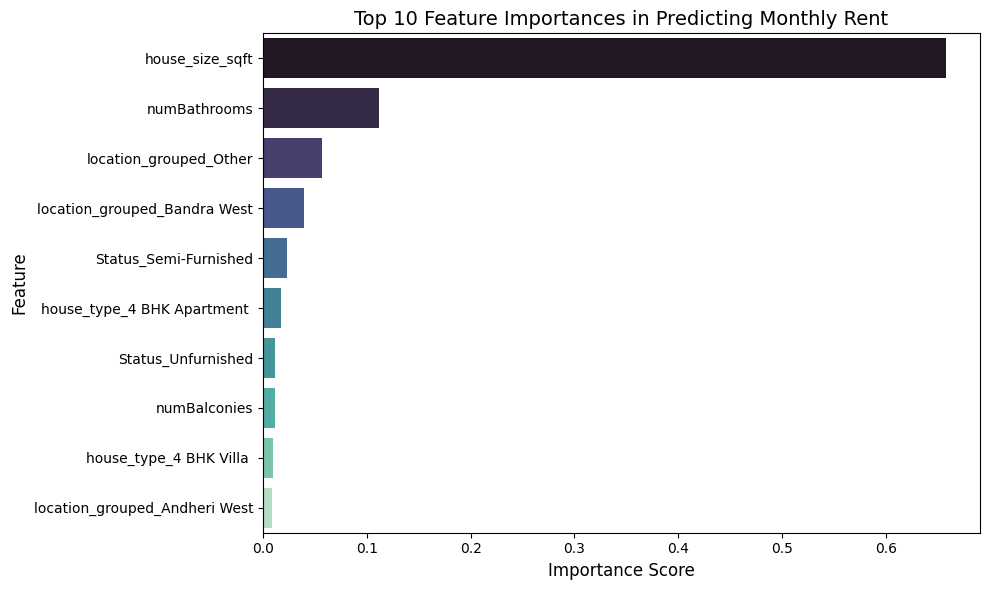

In [16]:
# Step 4 - Extract Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="mako")
plt.title('Top 10 Feature Importances in Predicting Monthly Rent', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()